# 1. Number of galaxies in the observable Universe from JWST NIRCam SMACS0723
# 2. Number of atoms in a star
# 3. Number of stars in a galaxy
# 4. -> Number of atoms in the OBSERVABLE Universe (at 0th order)

### Pr Hervé Dole - Université Paris-Saclay - 20241215 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sep
from astropy.io import fits
from astropy import wcs as WCS
from matplotlib.patches import Ellipse
from astropy.io import fits
import math
import scipy.constants as constants

# <u> Part 1.  Number of galaxies in the Universe from JWST NIRCam SMACS0723</u>

## A- Measure how many Galaxies are detected in SMACS0723 

a) Read JWST image at f356
Retrieve the image here: https://mast.stsci.edu/search/ui/#/jwst/results?resolve=true&target=SMACS0723&data_types=image,measurements&instruments=NIRCAM&radius=3&radius_units=arcminutes&useStore=false

In [2]:
mypath = '' # put the path here
mypath = '/Users/sst/JWST/ERO/SMACS_CS/JWST-SMACS-NIRCAM/'
filename = mypath + 'jw02736-o001_t001_nircam_clear-f356w_i2d.fits'

In [3]:
img_356,hdr_356 = fits.getdata(filename,header = True)
wcs_356 = WCS.WCS(hdr_356)

Set DATE-AVG to '2022-06-07T04:05:22.557' from MJD-AVG.
Set DATE-END to '2022-06-07T05:14:03.242' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.882362 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675125371.781 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


b) Source Extraction w/ sep

Check https://sep.readthedocs.io/en/stable/tutorial.html

In [4]:
nb_sigma = 3 # threshold
sep.set_extract_pixstack(1000000) # to get enough memory for source detection

newimg = img_356.astype(np.float64)

bkg = sep.Background(newimg)

data_sub = newimg - bkg

objects = sep.extract(data_sub, nb_sigma, err=bkg.globalrms)

c) Get the number of detected sources (galaxies) 

In [5]:
objects_detected = objects
number_of_observed_galaxies_in_SMACS0723 = objects_detected.size
number_of_observed_galaxies_in_SMACS0723

4448

(number is usually around 4400 galaxies)

d) Plot Extracted sources 

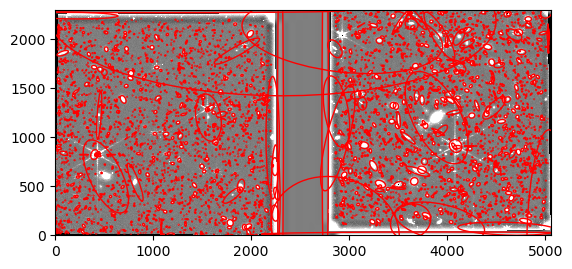

In [6]:
# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.median(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-0.2*s, vmax=m+0.2*s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

We see that the number of galaxies extracted is good to a percent level, say ~40 bad detections by eye out of 4000 -> less than 1% 

## B- Compute the observed sky area 

a) Now get the number of pixels observed

In [7]:
goodpixels, badpixels = np.where(data_sub > 0)

In [8]:
number_of_good_pixels = np.count_nonzero(goodpixels)
number_total_of_pixels = data_sub.size
print(number_of_good_pixels) # ': observed pixels'
print(number_total_of_pixels) # ': total number of pixels in image'

6842175
11647662


b) Now get the surface of each pixel


In [9]:
pixel_surface_arcsec2 = hdr_356['PIXAR_A2']

c) Now get the observed surface in arcsec^2

In [10]:
observed_surface_arcsec2 = pixel_surface_arcsec2 * number_of_good_pixels

In [11]:
print("{:.3e}".format(observed_surface_arcsec2))

2.708e+04


## C- Compute the surface of the whole sky in arcsec^2, knowing it is 4pi sr and estimate factor needed

a) Compute the sky solid angle ('surface') in arcsec^2

In [12]:
surface_all_sky_arcsec2 = 4. * math.pi * (180./math.pi)**2. * (3600.)**2.

In [13]:
print("{:.3e}".format(surface_all_sky_arcsec2))

5.346e+11


surface_all_sky_arcsec2 should be around 5.346e+11

b) Compute first the factor to multiply our observed surface to get the whole sky

In [14]:
factor_sky_surface = surface_all_sky_arcsec2 / observed_surface_arcsec2

In [15]:
print("{:.3e}".format(factor_sky_surface))

1.975e+07


## D- Compute the number of Galaxies in the whole sky from the observed galaxies in SMACS0723

In [16]:
number_galaxies_total = factor_sky_surface * number_of_observed_galaxies_in_SMACS0723

In [17]:
print("{:.3e}".format(number_galaxies_total))

8.783e+10


Number of Galaxies in the Observable Universe should be around 8.783e10

# <u>Part 2. Number of Atoms in a star</u>

a) First get the mass of the Sun, using the 3rd Kepler law and the Earth

In [18]:
a_earth_m = 150.e6 * 1.e3 # semi-major axis of the Earth Orbit in m

In [19]:
t_earth_s = 1. * 365. * 24. * 60. * 60. # Period of Eart revolution in seconds

In [20]:
Msun_kg = a_earth_m**3 / t_earth_s**2 * 4. * math.pi**2 / constants.G

In [21]:
print("{:.3e}".format(Msun_kg))

2.007e+30


b) As the stars are mainly composed of H, get the mass of 1 atom of H

In [22]:
print("{:.3e}".format(constants.proton_mass))

1.673e-27


c) Ratio both to get the number of atoms

In [23]:
number_atoms_in_star = Msun_kg / constants.proton_mass

In [24]:
print("{:.3e}".format(number_atoms_in_star))

1.200e+57


# <u>Part 3. Number of Stars in a Galaxy</u>

a) We use Kepler's 3rd law to get the typical mass of a galaxy 

We use r=30 000 light-years and T=200 Myr for a revolution of a star arounf its galaxy 

In [25]:
a_galaxy_kepler_ly = 30000.

In [26]:
constants.c, constants.G

(299792458.0, 6.6743e-11)

In [27]:
a_galaxy_kepler_m = a_galaxy_kepler_ly * 365. * 24. * 60. * 60. * constants.c # now in m

In [28]:
print("{:.3e}".format(a_galaxy_kepler_m))

2.836e+20


In [29]:
T_galaxy_kepler_yr = 200.e6

In [30]:
T_galaxy_kepler_s = T_galaxy_kepler_yr * 365. * 24. * 60. * 60. # now in seconds

In [31]:
print("{:.3e}".format(T_galaxy_kepler_s))

6.307e+15


In [32]:
mass_galaxy_kg = a_galaxy_kepler_m**3 / T_galaxy_kepler_s**2 * 4.* math.pi**2 / constants.G

In [33]:
print("{:.3e}".format(mass_galaxy_kg))

3.393e+41


b) now divide by the mass of a star (computed above) to get the number of stars

In [34]:
mass_star_kg = Msun_kg #about 1.e30

In [35]:
number_of_stars_in_galaxy = mass_galaxy_kg / mass_star_kg

In [36]:
print("{:.3e}".format(number_of_stars_in_galaxy))

1.690e+11


# <u>Part 4. Number of atoms in the OBSERVABLE Universe (at 0th order) </u> 

We multiply: the number of atoms in a star * number of star in a galaxy * number of galaxies in the observable Universe -> to get numbers of atoms in the observable universe

In [37]:
number_atoms_in_observable_universe = number_atoms_in_star * number_of_stars_in_galaxy * number_galaxies_total

In [38]:
print("{:.3e}".format(number_atoms_in_observable_universe))

1.781e+79


-> The number of atoms in the observable Universe (as seen in galaxies by extrapolating deep JWST observations) is __~3.e79__ !!!!

# <u>Parts 4bis. Corrected number of atoms in the observable Universe (1st order)</u>

BUT looking at only galaxies misses a lot of atoms (baryons), see for instance:
- Fukugita & Peebles 2004 ApJ : https://arxiv.org/abs/astro-ph/0406095 (factor about 24/16 -> 1.5)
- Nicastro et al., 2018, Nat : https://arxiv.org/abs/1806.08395 (factor about 100/7 -> 14)
- Ettori, 2003, MNRAS : https://arxiv.org/abs/astro-ph/0305296 (factor about 100/13 -> 7.7)

THUS, we need to correct fo the 'unseen' baryons present outside galaxies. We will be using the range 1.5-14.

In [39]:
number_atoms_in_observable_universe_corrected_minus = number_atoms_in_observable_universe * 1.5

In [40]:
number_atoms_in_observable_universe_corrected_plus = number_atoms_in_observable_universe * 14.

In [41]:
print("{:.3e}".format(number_atoms_in_observable_universe_corrected_minus))
print("{:.3e}".format(number_atoms_in_observable_universe_corrected_plus))

2.672e+79
2.494e+80


An order of magnitude can be taken at __1.e80__ for __the number of atoms in the observable Universe__.